Nesessary libraries connected

In [3]:
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split
import numpy as np
import os
import tensorflow as tf
import random
import opendatasets as od

In [4]:
filename = "Rice_Image_Dataset"
if not os.path.exists(filename):
    print("Downloading the dataset...")
    od.download("https://www.kaggle.com/datasets/muratkokludataset/rice-image-dataset?select=Rice_Image_Dataset")
else:
    print("Dataset file already exists.")

Skipping, found downloaded files in ".\rice-image-dataset" (use force=True to force download)


Categories: ['Arborio', 'Basmati', 'Ipsala', 'Jasmine', 'Karacadag']
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


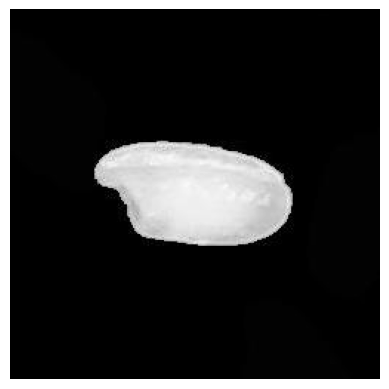

In [5]:
directory = 'rice-image-dataset/Rice_Image_Dataset'

categories = [folder for folder in os.listdir(directory) if os.path.isdir(os.path.join(directory, folder))]

print("Categories:", categories)

for cl in categories:
    path = os.path.join(directory, cl)
    for img_path in os.listdir(path):
        img = cv2.imread(os.path.join(path, img_path), cv2.IMREAD_GRAYSCALE)
        plt.imshow(img, cmap="gray")
        plt.axis('off')
        break
    break

print(img)

In [6]:
def image_preprocessing(img):
    img = cv2.GaussianBlur(img, (3, 3), 0) #Removing noise from the pictures (increased accuracy by 1 percent)
    img_blurred = cv2.medianBlur(img, 3)
    img_gray = cv2.cvtColor(img_blurred, cv2.COLOR_BGR2GRAY)
    resized = cv2.resize(img_gray, (128,128))
    normalized = resized/255.0
    sobel_x = cv2.Sobel(normalized, cv2.CV_64F, 1, 0, ksize=3)  # Sobel in x direction
    sobel_y = cv2.Sobel(normalized, cv2.CV_64F, 0, 1, ksize=3)  # Sobel in y direction
    sobel_magnitude = cv2.magnitude(sobel_x, sobel_y)
    return sobel_magnitude

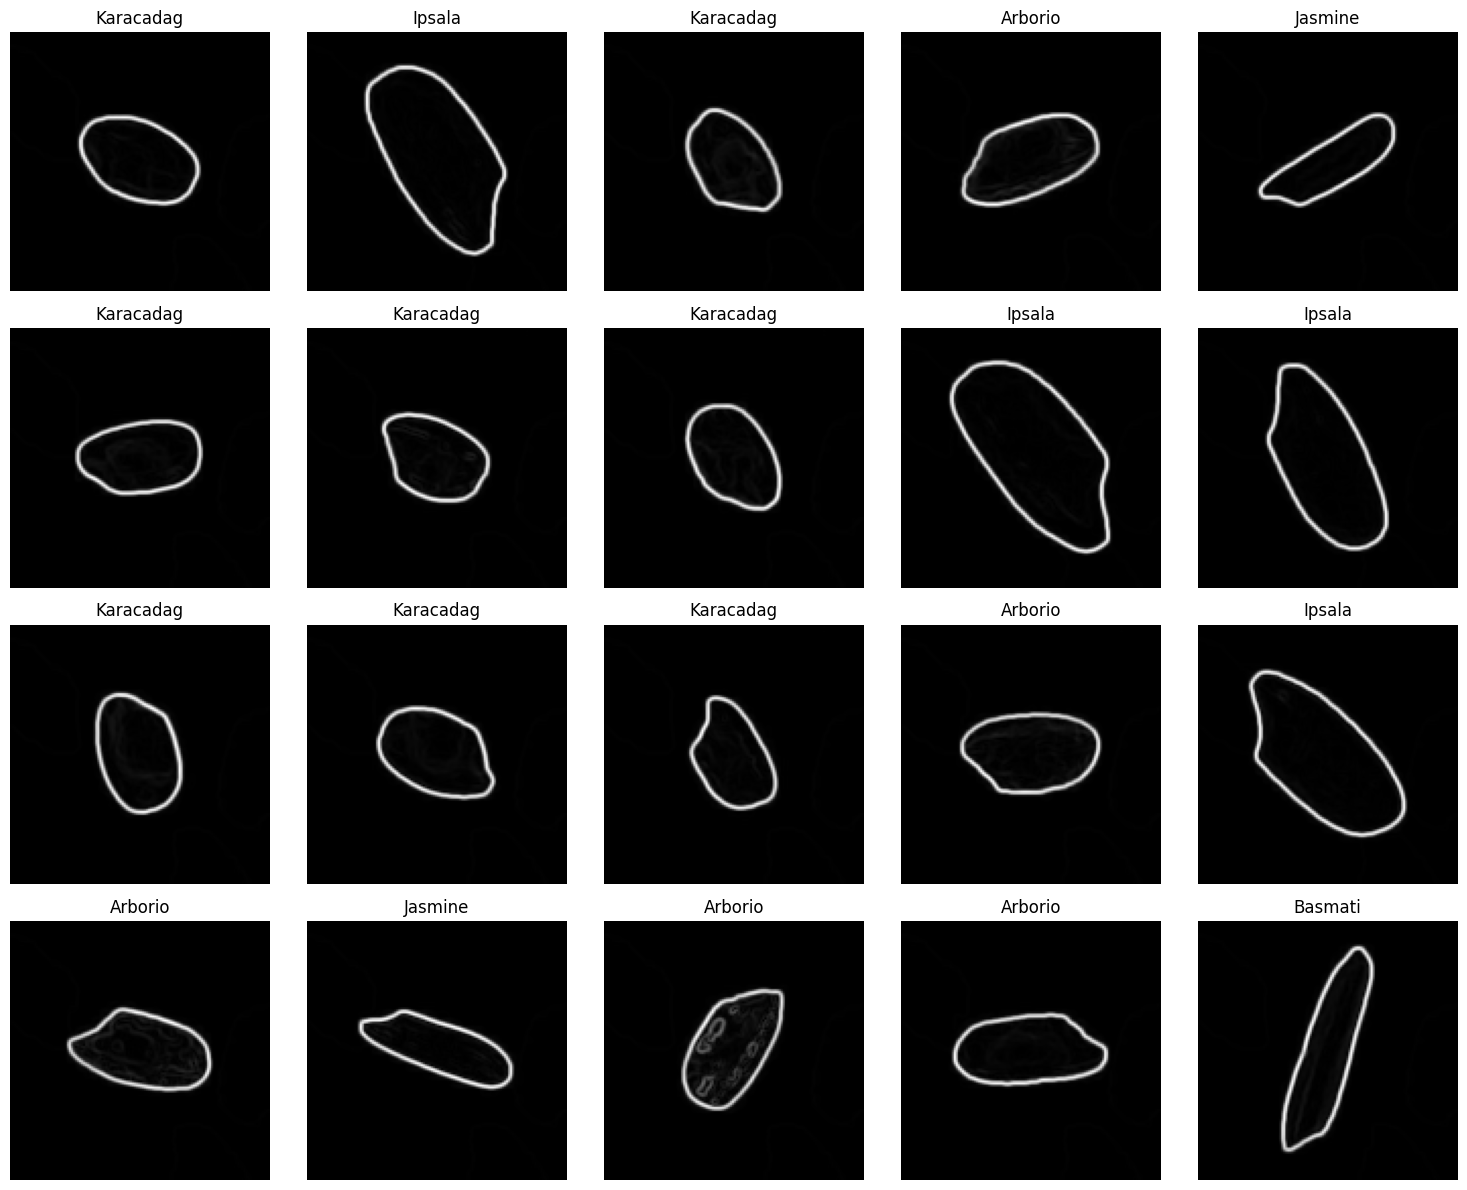

In [7]:
animals = []
for cl in categories:
    cls_num = categories.index(cl)
    path = os.path.join(directory, cl)
    for img in os.listdir(path):
        try:
            img = cv2.imread(os.path.join(path, img))
            preprocessed_image = image_preprocessing(img)  # Apply preprocessing
            if preprocessed_image is not None:
                animals.append([preprocessed_image, cls_num])  # Add only [image, label]
        except Exception as e:
            print(f"Error processing image: {e}")

random.shuffle(animals)

# Display Images
num_display = min(20, len(animals))
num_rows = (num_display + 4) // 5
plt.figure(figsize=(15, num_rows * 3))
for i, (img, cls_num) in enumerate(animals[:num_display]):
    plt.subplot(num_rows, 5, i + 1)
    plt.imshow(img, cmap='gray')  # Display grayscale image
    plt.title(categories[cls_num])
    plt.axis('off')
plt.tight_layout()
plt.show()

In [8]:
x = []
y = []

for idx, (pic, label) in enumerate(animals):
    resized_pic = cv2.resize(pic, (128, 128))
    x.append(resized_pic)
    y.append(label)

x = np.array(x)/255.0
y = np.array(y)
# First split: 10% for testing, 90% for training and validation
x_train_val, x_test, y_train_val, y_test = train_test_split(x, y, test_size=0.1, random_state=0)

# Second split: 10/90 of the remaining data (i.e., ~11% of the original data) for validation, 80% for training
x_train, x_val, y_train, y_val = train_test_split(x_train_val, y_train_val, test_size=0.1111, random_state=0)

print(f"Images length: {len(x)}")
print(f"Labels length: {len(y)}")

Images length: 75000
Labels length: 75000


In [9]:
# Define a CustomConv2D layer to handle multiple filters
class CustomConv2D(tf.keras.layers.Layer):
    def __init__(self, filters, kernel_size, kernel_initializer=None, padding="valid", activation=None, **kwargs):
        super(CustomConv2D, self).__init__(**kwargs)
        self.filters = filters
        self.kernel_size = kernel_size
        self.padding = padding
        self.activation = tf.keras.activations.get(activation)
        self.kernel_initializer = kernel_initializer

    def build(self, input_shape):
        # Use predefined kernels if provided, otherwise initialize normally
        kernel_shape = (*self.kernel_size, input_shape[-1], self.filters)
        if self.kernel_initializer is not None:
            self.kernel = self.add_weight(name="kernel",
                                          shape=kernel_shape,
                                          initializer=tf.constant_initializer(self.kernel_initializer),
                                          trainable=True)
        else:
            self.kernel = self.add_weight(name="kernel",
                                          shape=kernel_shape,
                                          initializer="glorot_uniform",
                                          trainable=True)


        # Initialize biases for each filter
        self.bias = self.add_weight(name="bias",
                                    shape=(self.filters,),
                                    initializer="zeros",
                                    trainable=True)

    def call(self, inputs):
        # Perform the convolution using multiple filters
        output = tf.nn.conv2d(inputs, self.kernel, strides=1, padding=self.padding.upper())
        # Add bias and apply the activation function, if specified
        output = tf.nn.bias_add(output, self.bias)
        if self.activation is not None:
            output = self.activation(output)
        return output

# Define example filters

sobel_x = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])

sobel_y = np.array([[-1, -2, -1],[ 0,  0,  0],[ 1,  2,  1]])

sharpening_filter = np.array([[ 0, -1,  0],[-1,  5, -1],[ 0, -1,  0]])  # Horizontal edge

# Stack the filters to shape (3, 3, 1, 3) for compatibility with CustomConv2D
predefined_kernels = np.stack([sobel_x, sobel_y, sharpening_filter], axis=-1)
predefined_kernels = np.expand_dims(predefined_kernels, axis=-2)  # Shape (3, 3, 1, 3)

# Define the CNN model with the CustomConv2D layer

gaussian_filter = np.array([[1, 2, 1], [2, 4, 2], [1, 2, 1]]) / 16
laplacian_filter = np.array([[0, 1, 0], [1, -4, 1], [0, 1, 0]])
emboss_filter = np.array([[-2, -1, 0], [-1, 1, 1], [0, 1, 2]])
box_blur = np.array([[1, 1, 1], [1, 1, 1], [1, 1, 1]]) / 9
diagonal_edge_filter = np.array([[2, -1, 0], [-1, 0, 1], [0, 1, -2]])
horizontal_edge_filter = np.array([[-1, -1, -1], [2, 2, 2], [-1, -1, -1]])
vertical_edge_filter = np.array([[-1, 2, -1], [-1, 2, -1], [-1, 2, -1]])

# Stack filters for the second layer
second_layer_kernels = np.stack(
    [gaussian_filter, laplacian_filter, emboss_filter, box_blur, diagonal_edge_filter], axis=-1
)
second_layer_kernels = np.expand_dims(second_layer_kernels, axis=-2)  # Shape (3, 3, 1, 5)

# Stack filters for the third layer
third_layer_kernels = np.stack(
    [sobel_x, sobel_y, horizontal_edge_filter, vertical_edge_filter], axis=-1
)
third_layer_kernels = np.expand_dims(third_layer_kernels, axis=-2)  # Shape (3, 3, 1, 4)

# Fix: Adjust filters to match input depth
def adapt_filters(filters, input_depth):
    """Expand filters to match the required input depth."""
    return np.tile(filters, (1, 1, input_depth, 1))  # Tile along the input depth axis

# Adjust filters for the second layer
second_layer_kernels = adapt_filters(second_layer_kernels, input_depth=3)  # Now (3, 3, 3, 5)

# Adjust filters for the third layer
third_layer_kernels = adapt_filters(third_layer_kernels, input_depth=5)  # Now (3, 3, 5, 4)

model = tf.keras.Sequential([
    # First CustomConv2D layer with predefined filters
    CustomConv2D(filters=3, kernel_size=(3, 3), kernel_initializer=predefined_kernels, padding="same", activation="relu", input_shape=(128, 128, 1)),
    tf.keras.layers.MaxPooling2D((2, 2)),

    # Second CustomConv2D layer with adjusted filters
    CustomConv2D(filters=5, kernel_size=(3, 3), kernel_initializer=second_layer_kernels, padding="same", activation="relu"),
    tf.keras.layers.MaxPooling2D((2, 2)),

    # Third CustomConv2D layer with adjusted filters
    CustomConv2D(filters=4, kernel_size=(3, 3), kernel_initializer=third_layer_kernels, padding="same", activation="relu"),
    tf.keras.layers.MaxPooling2D((2, 2)),

    # Dropout for regularization
    tf.keras.layers.Dropout(0.25),

    # Flatten and fully connected layers
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dropout(0.5),  # Dropout for fully connected layers
    tf.keras.layers.Dense(10, activation="softmax")  # Output layer
])

# Compile the model
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# Model summary to verify setup
model.summary()

# Train the model (optional, requires the full dataset and a longer training process)
model.fit(x_train, y_train, epochs=20, validation_data=(x_val, y_val))

# Evaluate the model (optional)
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f"Test accuracy: {test_acc}")

C:\Users\bprid\AppData\Local\Temp\ipykernel_10228\2269203799.py:4: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(CustomConv2D, self).__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ custom_conv2d (CustomConv2D)    │ (None, 128, 128, 3)    │            30 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ custom_conv2d_1 (CustomConv2D)  │ (None, 64, 64, 5)      │           140 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 5)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ custom_conv2d_2 (CustomConv2D)  │ (None, 32, 32, 4)      │           184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 4)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 16, 4)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 132,844 (518.92 KB)

 Trainable params: 132,844 (518.92 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 16s 7ms/step - accuracy: 0.8789 - loss: 0.3387 - val_accuracy: 0.9716 - val_loss: 0.0888
Epoch 2/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - accuracy: 0.9542 - loss: 0.1333 - val_accuracy: 0.9676 - val_loss: 0.0881
Epoch 3/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - accuracy: 0.9590 - loss: 0.1230 - val_accuracy: 0.9692 - val_loss: 0.0852
Epoch 4/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - accuracy: 0.9594 - loss: 0.1193 - val_accuracy: 0.9696 - val_loss: 0.0848
Epoch 5/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - accuracy: 0.9614 - loss: 0.1134 - val_accuracy: 0.9708 - val_loss: 0.0831
Epoch 6/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 14s 8ms/step - accuracy: 0.9653 - loss: 0.1069 - val_accuracy: 0.9705 - val_loss: 0.0856
Epoch 7/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - accuracy: 0.9639 - loss: 0.1069 - val_accuracy: 0.9708 - val_loss: 0.0825
Epoch 8/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - accuracy: 0.9645 - loss: 0

data augmentation